# ML algorithm spot check 

Table of Contents
1. [Read in cleaned data](#cleaned)
1. [Spot check XGBoost](#xgboost)
1. [Spot check Multilayer Perceptron](#mlp)

## Read in the cleansed data <a name="cleaned"></a>

In [6]:
import pandas as pd
import numpy as np
import sklearn

In [8]:
prepared_data_dir = 'data/processed'

In [9]:
processed = pd.read_pickle("{}/cooked_v3.pkl".format (prepared_data_dir))

In [7]:
processed.info ()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1514100 entries, 2017-07-03 08:00:00 to 2017-07-31 20:00:00
Data columns (total 14 columns):
StartPrice        1502293 non-null float64
MaxPrice          1502293 non-null float64
MinPrice          1502293 non-null float64
EndPrice          1502293 non-null float64
TradedVolume      1514100 non-null float64
NumberOfTrades    1514100 non-null float64
HourOfDay         1514100 non-null int64
MinOfHour         1514100 non-null int64
MinOfDay          1514100 non-null int64
DayOfWeek         1514100 non-null int64
DayOfYear         1514100 non-null int64
MonthOfYear       1514100 non-null int64
WeekOfYear        1514100 non-null int64
Mnemonic          1514100 non-null category
dtypes: category(1), float64(6), int64(7)
memory usage: 163.2 MB


In [8]:
processed.sample(5)

,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,HourOfDay,MinOfHour,MinOfDay,DayOfWeek,DayOfYear,MonthOfYear,WeekOfYear,Mnemonic
CalcDateTime,,,,,,,,,,,,,,
2017-07-10 11:33:00,34.525,34.535,34.525,34.535,0.0,0.0,11,33,693,0,191,7,28,DEQ
2017-07-14 16:45:00,13.775,13.775,13.775,13.775,0.0,0.0,16,45,1005,4,195,7,28,TEG
2017-07-10 09:54:00,1.799,1.799,1.799,1.799,2281.0,1.0,9,54,594,0,191,7,28,TINA
2017-07-18 11:04:00,13.685,13.685,13.685,13.685,188.0,1.0,11,4,664,1,199,7,29,SANT
2017-07-27 09:55:00,51.710,51.720,51.670,51.680,757.0,9.0,9,55,595,3,208,7,30,UTDI


In [9]:
processed.head (5)

,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,HourOfDay,MinOfHour,MinOfDay,DayOfWeek,DayOfYear,MonthOfYear,WeekOfYear,Mnemonic
CalcDateTime,,,,,,,,,,,,,,
2017-07-03 08:00:00,15.830,15.830,15.820,15.825,6594.0,9.0,8,0,480,0,184,7,27,DBK
2017-07-03 08:01:00,15.835,15.835,15.795,15.800,120179.0,29.0,8,1,481,0,184,7,27,DBK
2017-07-03 08:02:00,15.800,15.805,15.775,15.785,32404.0,29.0,8,2,482,0,184,7,27,DBK
2017-07-03 08:03:00,15.785,15.815,15.785,15.805,34169.0,58.0,8,3,483,0,184,7,27,DBK
2017-07-03 08:04:00,15.805,15.805,15.795,15.805,26589.0,31.0,8,4,484,0,184,7,27,DBK


In [10]:
selected = processed[processed['Mnemonic'].isin(['EOAN', 'BMW', 'SAP'])]
selected.Mnemonic.cat.remove_unused_categories (inplace=True)

In [11]:
selected.head(5)

,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,HourOfDay,MinOfHour,MinOfDay,DayOfWeek,DayOfYear,MonthOfYear,WeekOfYear,Mnemonic
CalcDateTime,,,,,,,,,,,,,,
2017-07-03 08:00:00,8.293,8.301,8.293,8.298,13532.0,12.0,8,0,480,0,184,7,27,EOAN
2017-07-03 08:01:00,8.297,8.297,8.297,8.297,264.0,1.0,8,1,481,0,184,7,27,EOAN
2017-07-03 08:02:00,8.300,8.300,8.284,8.285,5180.0,9.0,8,2,482,0,184,7,27,EOAN
2017-07-03 08:03:00,8.286,8.293,8.282,8.285,20331.0,29.0,8,3,483,0,184,7,27,EOAN
2017-07-03 08:04:00,8.282,8.285,8.279,8.282,11333.0,27.0,8,4,484,0,184,7,27,EOAN


## Forecast with XGBoost <a name="xgboost"></a>

In [2]:
!pip install xgboost

    100% |████████████████████████████████| 16.6MB 3.1MB/s 
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import xgboost

In [11]:
def create_xgb_target (df):
    return df.MaxPrice.shift(-1).fillna (method='ffill')

In [12]:
def create_xgb_features (df, horizon):
    n_df = df.copy ()
    
    for offset in range(1, horizon+1):
        min_price = n_df['MinPrice'].shift (offset).fillna(method='bfill')
        max_price = n_df['MaxPrice'].shift (offset).fillna(method='bfill')
        start_price = n_df['StartPrice'].shift (offset).fillna(method='bfill')
        end_price = n_df['EndPrice'].shift (offset).fillna(method='bfill')
        trade_vol = n_df['TradedVolume'].shift (offset).fillna(method='bfill')
        num_trades = n_df['NumberOfTrades'].shift (offset).fillna(method='bfill')
        
        n_df["h{}_MinPrice".format (offset)] = min_price
        n_df["h{}_MaxPrice".format (offset)] = max_price
        n_df["h{}_StartPrice".format (offset)] = start_price
        n_df["h{}_EndPrice".format (offset)] = end_price
        n_df["h{}_TradeVolume".format (offset)] = trade_vol
        n_df["h{}_NumberOfTrades".format (offset)] = num_trades
        
    return n_df

In [13]:
xgb_data = create_xgb_features (selected, 5)
xgb_data['NextMaxPrice'] = create_xgb_target (xgb_data)
pd.options.display.max_columns=150
xgb_data.head(5)

,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,HourOfDay,MinOfHour,MinOfDay,DayOfWeek,DayOfYear,MonthOfYear,WeekOfYear,Mnemonic,h1_MinPrice,h1_MaxPrice,h1_StartPrice,h1_EndPrice,h1_TradeVolume,h1_NumberOfTrades,h2_MinPrice,h2_MaxPrice,h2_StartPrice,h2_EndPrice,h2_TradeVolume,h2_NumberOfTrades,h3_MinPrice,h3_MaxPrice,h3_StartPrice,h3_EndPrice,h3_TradeVolume,h3_NumberOfTrades,h4_MinPrice,h4_MaxPrice,h4_StartPrice,h4_EndPrice,h4_TradeVolume,h4_NumberOfTrades,h5_MinPrice,h5_MaxPrice,h5_StartPrice,h5_EndPrice,h5_TradeVolume,h5_NumberOfTrades,NextMaxPrice
CalcDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-03 08:00:00,8.293,8.301,8.293,8.298,13532.0,12.0,8,0,480,0,184,7,27,EOAN,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.297
2017-07-03 08:01:00,8.297,8.297,8.297,8.297,264.0,1.0,8,1,481,0,184,7,27,EOAN,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.300
2017-07-03 08:02:00,8.300,8.300,8.284,8.285,5180.0,9.0,8,2,482,0,184,7,27,EOAN,8.297,8.297,8.297,8.297,264.0,1.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293
2017-07-03 08:03:00,8.286,8.293,8.282,8.285,20331.0,29.0,8,3,483,0,184,7,27,EOAN,8.284,8.300,8.300,8.285,5180.0,9.0,8.297,8.297,8.297,8.297,264.0,1.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.285
2017-07-03 08:04:00,8.282,8.285,8.279,8.282,11333.0,27.0,8,4,484,0,184,7,27,EOAN,8.282,8.293,8.286,8.285,20331.0,29.0,8.284,8.300,8.300,8.285,5180.0,9.0,8.297,8.297,8.297,8.297,264.0,1.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.293,8.301,8.293,8.298,13532.0,12.0,8.283


In [14]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split (xgb_data, train_size=0.8, shuffle=False)
train_data, validate_data = train_test_split (train_data, train_size=0.8, test_size=0.2, shuffle=True)

train_labels = train_data.NextMaxPrice
validate_labels = validate_data.NextMaxPrice
test_labels = test_data.NextMaxPrice

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [15]:
train_data.drop ("NextMaxPrice", axis=1, inplace=True)
validate_data.drop ("NextMaxPrice", axis=1, inplace=True)
test_data.drop ('NextMaxPrice', axis = 1, inplace=True)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [16]:
train_features = pd.get_dummies(train_data)
validate_features = pd.get_dummies(validate_data)
test_features = pd.get_dummies(test_data)
train_features.head(5)

,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,HourOfDay,MinOfHour,MinOfDay,DayOfWeek,DayOfYear,MonthOfYear,WeekOfYear,h1_MinPrice,h1_MaxPrice,h1_StartPrice,h1_EndPrice,h1_TradeVolume,h1_NumberOfTrades,h2_MinPrice,h2_MaxPrice,h2_StartPrice,h2_EndPrice,h2_TradeVolume,h2_NumberOfTrades,h3_MinPrice,h3_MaxPrice,h3_StartPrice,h3_EndPrice,h3_TradeVolume,h3_NumberOfTrades,h4_MinPrice,h4_MaxPrice,h4_StartPrice,h4_EndPrice,h4_TradeVolume,h4_NumberOfTrades,h5_MinPrice,h5_MaxPrice,h5_StartPrice,h5_EndPrice,h5_TradeVolume,h5_NumberOfTrades,Mnemonic_BMW,Mnemonic_EOAN,Mnemonic_SAP
CalcDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-14 16:02:00,8.573,8.576,8.572,8.574,0.0,0.0,16,2,962,4,195,7,28,8.572,8.576,8.573,8.574,0.0,0.0,8.572,8.576,8.573,8.574,0.0,0.0,8.572,8.576,8.573,8.574,0.0,0.0,8.572,8.576,8.573,8.574,0.0,0.0,8.572,8.576,8.573,8.574,0.0,0.0,0,1,0
2017-07-17 10:38:00,8.587,8.588,8.587,8.587,8875.0,7.0,10,38,638,0,198,7,29,8.586,8.587,8.586,8.587,4492.0,6.0,8.585,8.585,8.585,8.585,1161.0,1.0,8.580,8.586,8.580,8.586,3698.0,5.0,8.582,8.588,8.586,8.582,10087.0,14.0,8.587,8.589,8.588,8.587,8463.0,5.0,0,1,0
2017-07-25 16:27:00,89.120,89.130,89.010,89.060,0.0,0.0,16,27,987,1,206,7,30,89.010,89.130,89.120,89.060,0.0,0.0,89.010,89.130,89.120,89.060,0.0,0.0,89.010,89.130,89.120,89.060,0.0,0.0,89.010,89.130,89.120,89.060,0.0,0.0,89.010,89.130,89.120,89.060,0.0,0.0,0,0,1
2017-07-04 10:37:00,90.900,90.930,90.860,90.930,3749.0,18.0,10,37,637,1,185,7,27,90.880,90.910,90.900,90.900,1907.0,14.0,90.880,90.940,90.910,90.890,2843.0,20.0,90.900,90.930,90.930,90.900,1162.0,9.0,90.930,90.940,90.940,90.940,466.0,3.0,90.930,90.960,90.950,90.930,1446.0,15.0,0,0,1
2017-07-04 17:40:00,82.560,82.570,82.500,82.530,0.0,0.0,17,40,1060,1,185,7,27,82.500,82.570,82.560,82.530,0.0,0.0,82.500,82.570,82.560,82.530,0.0,0.0,82.500,82.570,82.560,82.530,0.0,0.0,82.500,82.570,82.560,82.530,0.0,0.0,82.500,82.570,82.560,82.530,0.0,0.0,1,0,0


In [18]:
model = xgboost.XGBRegressor (n_estimators=500)
model.fit (train_features, train_labels, 
           eval_set=[(train_features, train_labels), (validate_features, validate_labels)],
           early_stopping_rounds = 50, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

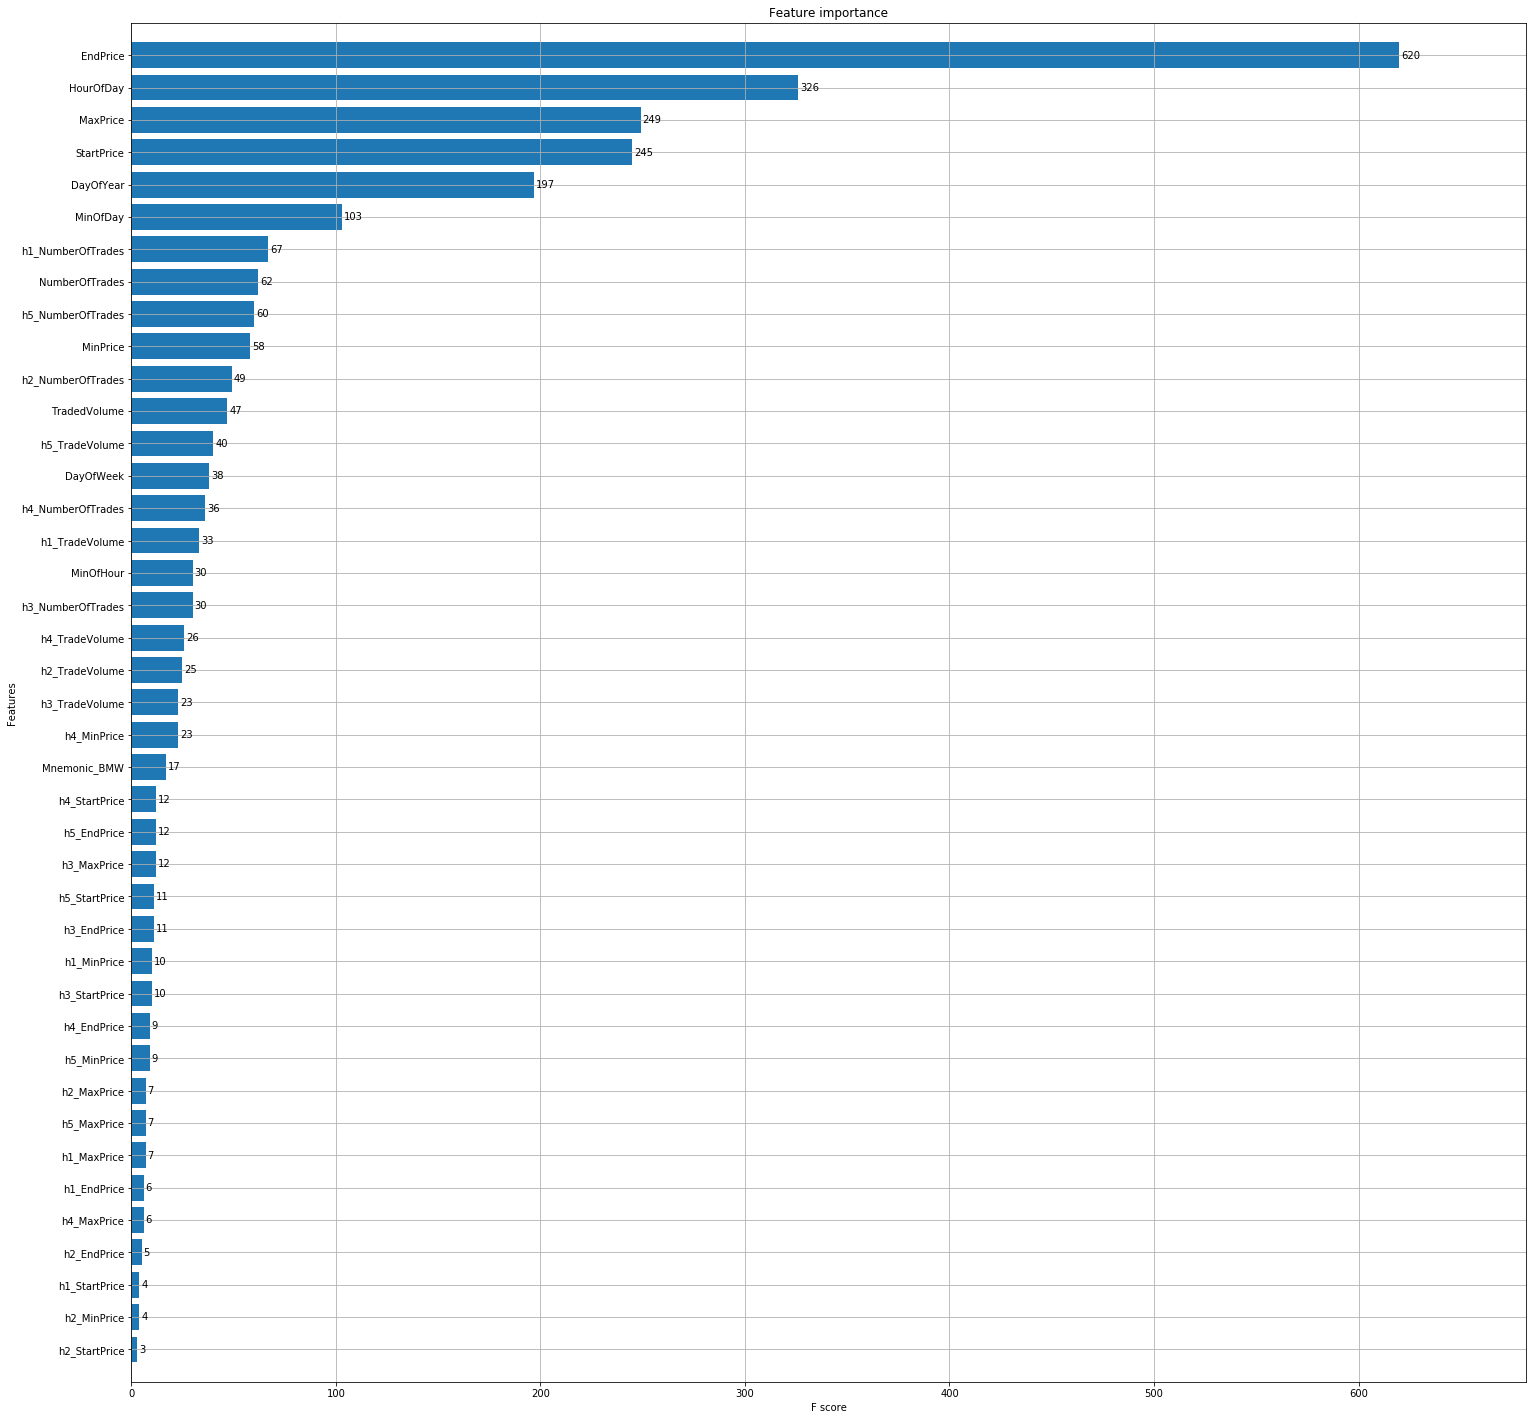

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(25,25))
plot_importance(model, height=0.8, ax=ax)

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
pred = model.predict (test_features)
print ("RMSE: {}".format (mean_squared_error (y_true = test_labels, y_pred = pred)))
print ("MAE: {}".format (mean_absolute_error (y_true = test_labels, y_pred = pred)))

RMSE: 2.255723572467886
MAE: 0.9962069630935158


In [26]:
test_labels.index.get_loc('2017-07-14 08:00:00')

433

In [17]:
from matplotlib import pyplot as plt

start_loc = test_labels.index.get_loc('2017-07-14 08:00:00')
end_loc = test_labels.index.get_loc('2017-07-14 20:00:00')
data = pd.DataFrame ()
data['True_Y'] = test_labels[start_loc:end_loc]
data['Pred_Y'] = pred[start_loc:end_loc]

data.plot (figsize=(25,10))

NameError: name 'pred' is not defined

## Forecasting with an MLP <a name="mlp"></a>

In [3]:
import mxnet as mx
from mxnet import nd, autograd, gluon

In [4]:
num_hidden_1 = 64
num_hidden_2 = 24
num_output = 1
learning_rate = 0.001
batch_size = 100
num_examples = 33233

model_ctx = mx.cpu ()
data_ctx = mx.cpu ()

In [18]:
train_dataset = gluon.data.dataset.ArrayDataset (nd.array(train_features), nd.array(train_labels))
train_dataloader = gluon.data.DataLoader (train_dataset, batch_size=batch_size)

validate_dataset = gluon.data.dataset.ArrayDataset (nd.array(validate_features), nd.array(validate_labels))
validate_dataloader = gluon.data.DataLoader (validate_dataset, batch_size=batch_size)

test_dataset = gluon.data.dataset.ArrayDataset (nd.array(test_features), nd.array(test_labels))
test_dataloader = gluon.data.DataLoader (test_dataset, batch_size=batch_size)

In [19]:
model = gluon.nn.Sequential ()
with model.name_scope ():
    model.add (gluon.nn.Dense (num_hidden_1, activation='relu'))
    model.add (gluon.nn.Dense (num_hidden_2, activation='relu'))
    model.add (gluon.nn.Dense (num_output))
    
model.collect_params().initialize(mx.init.Normal(sigma=.1), ctx=model_ctx)
l2loss = gluon.loss.L2Loss ()
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': learning_rate})


In [20]:
def evaluate_accuracy(data_iterator, model):
    rmse = mx.metric.RMSE ()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1, 46))
        label = label.as_in_context(model_ctx)
        output = model(data)
        predictions = output # predictions = nd.argmax(output, axis=1)
        rmse.update(preds=predictions, labels=label)
    return rmse.get()[1]

In [21]:
epochs = 50
smoothing_constant = .01

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_dataloader):
        data = data.as_in_context(model_ctx).reshape((-1, 46))
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = model(data)
            loss = l2loss(output, label)
        loss.backward()
        trainer.step(data.shape[0])
        cumulative_loss += nd.sum(loss).asscalar()

    validate_accuracy = evaluate_accuracy(validate_dataloader, model)
    train_accuracy = evaluate_accuracy(train_dataloader, model)
    print("Epoch %s. Loss: %s, Train_acc %s, Validate_acc %s" %
          (e, cumulative_loss/num_examples, train_accuracy, validate_accuracy))

Epoch 0. Loss: 2174.20278995, Train_acc 22.9244117868, Validate_acc 22.9999784966
Epoch 1. Loss: 204.487343454, Train_acc 23.0841149301, Validate_acc 24.1242328409
Epoch 2. Loss: 140.061472505, Train_acc 14.9174334634, Validate_acc 15.7156938788
Epoch 3. Loss: 90.9642459496, Train_acc 13.0904327504, Validate_acc 13.7787243503
Epoch 4. Loss: 76.1250365994, Train_acc 11.5680834796, Validate_acc 12.3221044802
Epoch 5. Loss: 67.788758968, Train_acc 10.0797617853, Validate_acc 10.4943172376
Epoch 6. Loss: 78.7409242983, Train_acc 9.98754535098, Validate_acc 10.1519401825
Epoch 7. Loss: 41.7392041237, Train_acc 8.34042139643, Validate_acc 8.68206282185
Epoch 8. Loss: 36.6263719476, Train_acc 6.48379370765, Validate_acc 6.95849756999
Epoch 9. Loss: 75.1358954724, Train_acc 7.75997401185, Validate_acc 7.81812344512
Epoch 10. Loss: 49.0119100622, Train_acc 5.89826026733, Validate_acc 6.27426826464
Epoch 11. Loss: 35.1428457546, Train_acc 5.7876189517, Validate_acc 6.02080562343
Epoch 12. Loss: 

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
pred = model(nd.array(test_features)).asnumpy ().reshape(-1)
print ("RMSE: {}".format (mean_squared_error (y_true = test_labels, y_pred = pred)))
print ("MAE: {}".format (mean_absolute_error (y_true = test_labels, y_pred = pred)))

RMSE: 0.27861946816128763
MAE: 0.29423307992602443


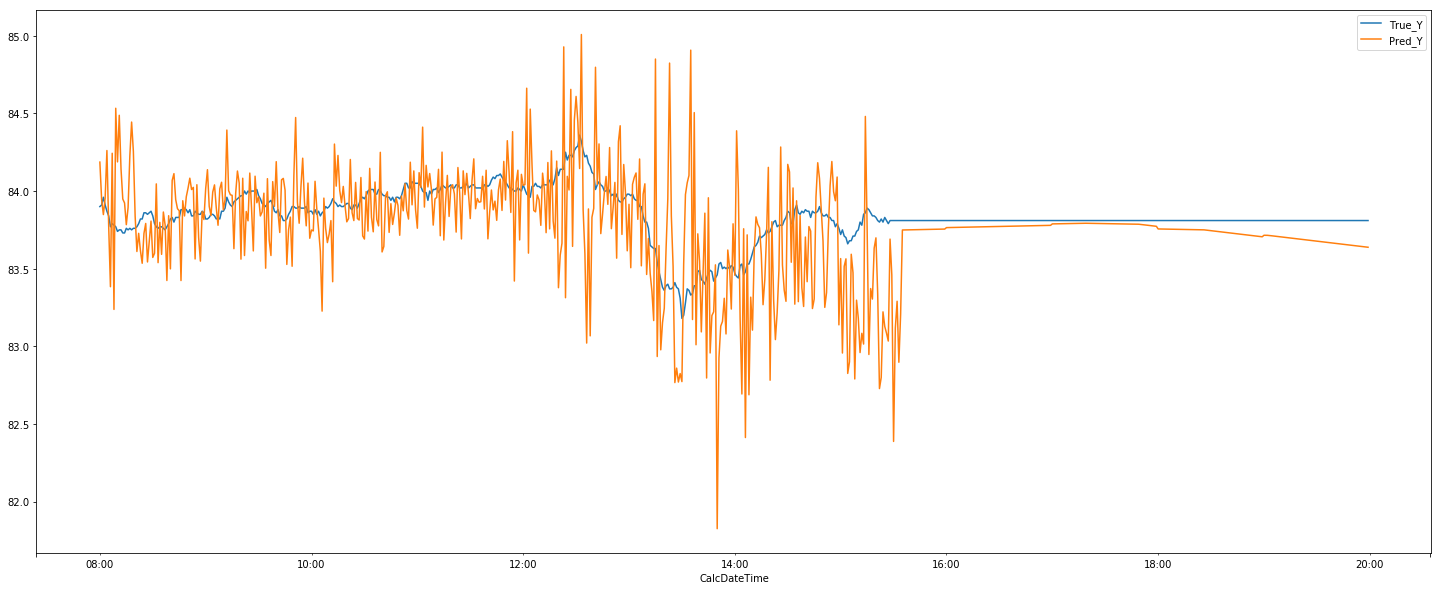

In [24]:
from matplotlib import pyplot as plt

start_loc = test_labels.index.get_loc('2017-07-14 08:00:00')
end_loc = test_labels.index.get_loc('2017-07-14 20:00:00')
data = pd.DataFrame ()
data['True_Y'] = test_labels[start_loc:end_loc]
data['Pred_Y'] = pred[start_loc:end_loc]

data.plot (figsize=(25,10))

---
Extra credit

## Forecasting with CNN

## Forecasting with LSTM

## Forecasting with DeepAR